In [ ]:
import os
import numpy as np
import matplotlib
import torch
!pip install mat73
import mat73
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

from scipy import signal

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import LeaveOneGroupOut






In [ ]:
from math import sqrt
import torch
import torch.nn.functional as F
from torch import nn
!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
#file_name_train=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/Data_allfilt_0.5_7.mat"

ExpVer='emg3'
FiltName='filt'+'_0.1_5'
file_name_train=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/Data_17_6_comb"+FiltName+".mat"

#file_name_train=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/Data_17_6_combfilt_0.05_10.mat"
data = mat73.loadmat(file_name_train)


feature_all = data['feature_all'][:,:,:]    ## waveform * channel * case 
feature_all=np.swapaxes(feature_all,0,2)
feature_all_c = data['feature_all_complex'][:,:,:]    ## waveform * channel * case 
feature_all_c=np.swapaxes(feature_all_c,0,2)
feature_all_emg = data['feature_all_emg'][:,:,:]    ## waveform * channel * case 
feature_all_emg=np.swapaxes(feature_all_emg,0,2)
self_channel=[0,1,10,11,20,21,30,31]

feature_all2=np.hstack((feature_all,feature_all_c))
label_all = data['label_all']
caseNum_all = data['caseNum_all']

Chan_Name = data['Chan_Name']

#truncate time length 
fs=500
ind=np.arange(fs*1, fs*6, 1, dtype=int)
feature_all2=feature_all2[:,:,ind]
feature_all_emg=feature_all_emg[:,:,ind]

Mounted at /content/drive


In [ ]:
feature_all=np.hstack((feature_all2,feature_all_emg))
def stft_2d(X):

  
  fs = 500
  f_th=56
  Zxx_all=np.zeros([X.shape[0],X.shape[1],f_th,f_th])
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      phase_data=X[i,j,:] 
      f, t, Zxx = signal.stft(phase_data, fs, nperseg=fs*0.6,noverlap = fs*0.52,nfft=fs*3.5,boundary = None)
      Zxx_out=Zxx[0:f_th,:]
      Zxx_all[i,j,:,:]=abs(Zxx_out)
  Zxx_all=np.array(Zxx_all)  
  return Zxx_all

feature_2d_stft=stft_2d(feature_all)

def stft_2d_v2(X):

  
  fs = 500
  f_th=41
  Zxx_all=np.zeros([X.shape[0],X.shape[1],f_th,f_th])
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      phase_data=X[i,j,:] 
      f, t, Zxx = signal.stft(phase_data, fs, nperseg=fs*1,noverlap = fs*0.9,nfft=fs*6,boundary = None)
    
      Zxx_out=Zxx[0:f_th,:]
      Zxx_all[i,j,:,:]=abs(Zxx_out)
  Zxx_all=np.array(Zxx_all)  
  return Zxx_all

feature_2d_stft2=stft_2d_v2(feature_all)

size_f=30
f=np.linspace(0.1,10,size_f)
def WT(dataIn):
  Ds=20
  fs=500/Ds
  dataIn = signal.resample(dataIn, int(dataIn.shape[2]/Ds),axis=2)
  # freqeucny range 
  widths =np.round(fs/f)  # frequency to widths range 

  Zxx_all=np.zeros([dataIn.shape[0],dataIn.shape[1],dataIn.shape[2],size_f])
  for i in range(dataIn.shape[0]):
    for j in range(dataIn.shape[1]):
      phase_data=dataIn[i,j,:]
     
      cwtmatr = signal.cwt(phase_data, signal.ricker, widths) # CWT transform 
      Zxx_out=cwtmatr.T 
      Zxx_all[i,j,:,:]=abs(Zxx_out)
  Zxx_all=np.array(Zxx_all)  
  return Zxx_all
    
feature_2d_cwt=WT(feature_all)

def WT2(dataIn):
  Ds=20
  fs=500/Ds
  dataIn = signal.resample(dataIn, int(dataIn.shape[2]/Ds),axis=2)
  # freqeucny range 
  widths =np.round(fs/f)  # frequency to widths range 

  Zxx_all=np.zeros([dataIn.shape[0],dataIn.shape[1],dataIn.shape[2],size_f])
  for i in range(dataIn.shape[0]):
    for j in range(dataIn.shape[1]):
      phase_data=dataIn[i,j,:]
     
      cwtmatr = signal.cwt(phase_data, signal.morlet2, widths) # CWT transform 
      Zxx_out=cwtmatr.T 
      Zxx_all[i,j,:,:]=abs(Zxx_out)
  Zxx_all=np.array(Zxx_all)  
  return Zxx_all
    
feature_2d_cwt2=WT2(feature_all)

import pywt
size_f=30
f=np.linspace(0.1,10,size_f)
def WT3(dataIn):
  Ds=20
  fs=500/Ds
  dataIn = signal.resample(dataIn, int(dataIn.shape[2]/Ds),axis=2)
  # freqeucny range 
  widths =np.round(fs/f)  # frequency to widths range 

  Zxx_all=np.zeros([dataIn.shape[0],dataIn.shape[1],dataIn.shape[2],size_f])
  for i in range(dataIn.shape[0]):
    for j in range(dataIn.shape[1]):
      phase_data=dataIn[i,j,:]
      cwtmatr, freqs = pywt.cwt(phase_data, widths,"cgau1")
      #print(cwtmatr.shape) # CWT transform 
      Zxx_out=cwtmatr.T 
      Zxx_all[i,j,:,:]=abs(Zxx_out)
  Zxx_all=np.array(Zxx_all)  
  return Zxx_all
feature_2d_cwt3=WT3(feature_all)  

feature_all=feature_all.astype('float16')
feature_2d_stft=feature_2d_stft.astype('float16')
feature_2d_stft2=feature_2d_stft2.astype('float16')
feature_2d_cwt=feature_2d_cwt.astype('float16')
feature_2d_cwt2=feature_2d_cwt2.astype('float16')
feature_2d_cwt3=feature_2d_cwt3.astype('float16')

np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/data_all_multi6_wEMG"+FiltName+".npz",feature_all=feature_all,\
                    feature_2d_stft=feature_2d_stft,feature_2d_stft2=feature_2d_stft2,\
                    feature_2d_cwt=feature_2d_cwt,\
                    feature_2d_cwt2=feature_2d_cwt2,feature_2d_cwt3=feature_2d_cwt3,\
                    label_all=label_all,caseNum_all=caseNum_all)


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning: Casting complex values to real discards the imaginary part
  output[ind] = convolve(data, wavelet_data, mode='same')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: ComplexWarning: Casting complex values to real discards the imaginary part


[[ 1.  8.]
 [ 2.  6.]
 [ 3.  8.]
 [ 4.  6.]
 [ 5.  9.]
 [ 6.  9.]
 [ 7.  7.]
 [ 8.  5.]
 [ 9.  8.]
 [10.  9.]
 [11. 11.]
 [12.  5.]]
0.1502366330160763
0.08861675105252109
0.019552148632950836
0.010810437602001233
0.005251683390293366
0.005036554944056731
0.0021762047474692156
0.004425604571844195
0.0012160050307465343
0.002567521183864101
0.0009306230387844882
0.0031499199282664517
0.0005819848670381984
0.0022404381882522133
0.00041168243769256076
0.0024351612613587588
0.0003138100860585824
0.0029425848695029924
0.00025870296558290175
0.0020891403994308068
0.00021009583447483324
0.0021827595390297556
0.00017325702292210127
0.0019795109190374285
0.00015180317438531654
0.0023387976267098725


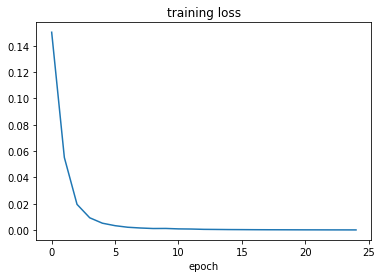

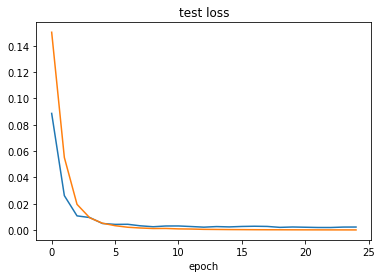

[[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 

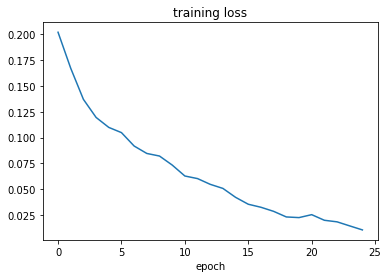

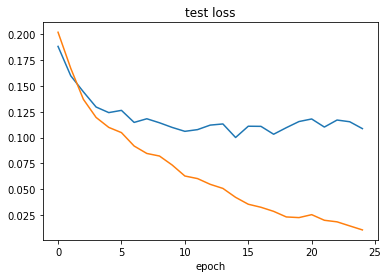

[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0]
 [1 0 0 0 0 0 0 0 0 

In [ ]:

num_class=23
dataPath="/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer
par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':128,'dropout':0.1,'emb_dropout':0.1};
folds=RepeatedStratifiedKFold(n_splits=7, n_repeats=1,random_state=100).split(feature_all,label_all)
#folds=StratifiedGroupKFold(n_splits=7).split(feature_2d_stft,label_all,caseNum_all)
for train_index, test_index in folds:
    test_ind=test_index
    train_ind=train_index


def test(X_all,y_all,opt):
  import torch
  torch.cuda.empty_cache()

  if __name__ == '__main__':
      
      transform = ToTensor()
      batchsize_train = 16

      X_train=X_all[train_ind] 
      X_test=X_all[test_ind]
      y_train=y_all[train_ind] 
      y_test=y_all[test_ind]

      train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
      batchsize_test = 16
      test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)
              
      (unique, counts) = np.unique(caseNum_all[test_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      #hyperparameter definition    
      learning_rate = 1e-4  #学习的速率 越小越精细
      momentum = 0.1
      random_seed=1
      torch.backends.cudnn.enabled = False
      torch.manual_seed(random_seed)     #设定随机数种子为固定值
      
      train_loss_epoch = []
      test_acc_epoch =[]
      total_acc_epoch = []
      #epoch_range = np.arange(25,225,25)
      epoch_range = np.array([2])

      
      #network = Net2().cuda()   # 2d cnn
        # 1d cnn
      # if opt['net']=='stft':
      #     network = MyViT((48, 56, 56), n_patches=7, hidden_d=20, n_heads=2, out_d=num_class).cuda()
      # if opt['net']=='stft2':
      #     network = MyViT((48, 41, 41), n_patches=7, hidden_d=20, n_heads=2, out_d=num_class).cuda()
      # if opt['net']=='stft3':
      #     network = Net2_stft3(in_ch,num_class).cuda()
      # if opt['net']=='cwt':
      #     network = Net2_cwt(in_ch,num_class).cuda()
      # if opt['net']=='cwt2':
      #     network = Net2_cwt(in_ch,num_class).cuda()
      # if opt['net']=='1d':
      #     network = Net(in_ch,num_class).cuda()

      network = ViT(
      image_size = opt['image_size'],
      patch_size = opt['patch_size'],
      num_classes =num_class,
      dim = par_vit['dim'],
      depth = par_vit['depth'],
      heads = par_vit['heads'],
      mlp_dim = par_vit['mlp_dim'],
      dropout = par_vit['dropout'],
      emb_dropout = par_vit['emb_dropout'],
      channels = in_ch
      ).cuda()
      #training
      optimizer = optim.Adam(network.parameters(), lr=learning_rate)
      #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
      

      #network.train()
      Training_Loss = []
      Test_Loss = []
      start_time = time.time()
      criterion = nn.CrossEntropyLoss()
      #criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3]).cuda())
      for epoch in range(25):   # loop over the dataset multiple times
          train_loss = 0
          for X, Y in train_loader:
              # X = X.view(-1,1,X.shape[2],X.shape[3]).cuda()
              X = X.float().cuda()  
              Y = Y.long().view(-1, ).cuda() 
              current_batchsize = X.shape[0]
              optimizer.zero_grad()
              output = network(X)
              loss = criterion(output,Y)
              train_loss = train_loss + loss.item()
              loss.backward()                     #calculate the gradient decent
              optimizer.step()                    #update the weight
              
            





          test_loss = 0
          correct = 0
          total = 0
          test_y= []
          test_y_p = []
          # sens = 0    # sensitivity = TP/(TP + FN)
          # prec = 0    # precision = TP/(TP + FP)
          with torch.no_grad():        
              # X = X.view(-1,X.shape[1],X.shape[2])
              # X = X.float()         
              for X, Y in test_loader:
                  X = torch.Tensor(X).cuda()
                  Y = torch.Tensor(Y).long().view(-1, ).cuda()
                  images, labels = X, Y
                  # calculate outputs by running images through the network
                  outputs = network(images)
                  loss = criterion(outputs,Y)
                  test_loss = test_loss + loss.item()

                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  
                  for i in range(len(labels)):
                    test_y.append(labels[i])
                    test_y_p.append(predicted[i])
          
          #print('Accuracy of test cases: %d %%' % (100 * correct / total))
  

          Training_Loss.append(train_loss/len(train_loader.dataset))
          Test_Loss.append(test_loss/len(test_loader.dataset))
          if epoch%2==0:
              print(train_loss/len(train_loader.dataset))
              print(test_loss/len(test_loader.dataset))
        
              
      # PATH=dataPath+"/model/"+opt['net']+".pt"
      # torch.save(network.state_dict(), PATH)
      # train_loss_epoch.append(Training_Loss[-1])
      # training_time=time.time()-start_time
      #print('total training time is',training_time)
      
      plt.figure()
      plt.plot(Training_Loss)
      plt.title("training loss")
      plt.xlabel("epoch")
      plt.show()

      plt.figure()
      plt.plot(Test_Loss)
      plt.title("test loss")
      plt.xlabel("epoch")
      plt.plot(Training_Loss)
      plt.show()

  test_y_p=torch.FloatTensor(test_y_p)
  test_y=torch.FloatTensor(test_y)
  test_y_p=np.array(test_y_p.cpu())
  test_y=np.array(test_y.cpu())
  test_y2=np.stack((test_y, test_y_p))



  cm=confusion_matrix(test_y, test_y_p)
  acc=accuracy_score(test_y, test_y_p)
  print(cm,acc)
  return cm,acc,test_y2
in_ch=48
#cm,acc,test_y2=test(feature_2d_stft,label_all,{'net':'stft'})
#cm,acc,test_y2=test(feature_all,label_all,{'net':'1d'})
# cm1,acc1,test_y1=test(feature_2d_stft[:,:32,:,:],label_all,{'net':'stft'})
cm2,acc2,test_y2=test(feature_2d_cwt2[:,:48,:,:],label_all,{'image_size':125,'patch_size':5})
in_ch=1
#cm,acc,test_y2=test(feature_2d_stft,label_all,{'net':'stft'})
#cm,acc,test_y2=test(feature_all,label_all,{'net':'1d'})
# cm1,acc1,test_y1=test(feature_2d_stft[:,:32,:,:],label_all,{'net':'stft'})
cm2,acc2,test_y2=test(feature_2d_cwt2[:,49:50,:,:],label_all,{'image_size':125,'patch_size':5})

# cm3,acc3,test_y3=test(feature_2d_stft3[:,:32,:,:],label_all,{'net':'stft3'})
# cm4,acc4,test_y4=test(feature_2d_cwt[:,:32,:,:],label_all,{'net':'cwt'})
# cm5,acc5,test_y5=test(feature_2d_cwt2[:,:32,:,:],label_all,{'net':'cwt2'})
# cm5,acc5,test_y5=test(feature_2d_cwt3[:,:32,:,:],label_all,{'net':'cwt'})

In [ ]:

y_ensemble=np.zeros([np.size(test_y1,axis=1),])
for i in range(np.size(test_y1,axis=1)):
  
  list=[test_y1[1,i],test_y2[1,i],test_y4[1,i],test_y5[1,i],test_y6[1,i]]
  
  (unique, counts) = np.unique(list, return_counts=True)

  label=unique[np.argmax(counts)]
  y_ensemble[i]=label


cm=confusion_matrix(test_y1[0,:], y_ensemble)
acc=accuracy_score(test_y1[0,:], y_ensemble)

print(acc,cm)

0.8932038834951457 [[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  1  0  0]
 [ 0  0  0  0  0  0  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ExpVer='2_19'
file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/data_all_multi6_wEMGfilt_0.1_5.npz"
data=np.load(file_name_data)
feature_2d_stft=data['feature_2d_stft']
feature_2d_stft2=data['feature_2d_stft2']
feature_2d_cwt=data['feature_2d_cwt']
feature_2d_cwt2=data['feature_2d_cwt2']
feature_2d_cwt3=data['feature_2d_cwt3']

label_all=data['label_all']
caseNum_all=data['caseNum_all']



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# in_ch: CNN input channel number 
# num_class: classification number  8,5,3 
# opt CV method. groupKfold: kfold, all cases not been seen in training set  
# Kfold : randomly kfold. label and cases equally distributed
# group: leave one case out 

par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':64,'dropout':0.1,'emb_dropout':0.1,\
         'n_epoch':25,'learning_rate':1e-4};    
parameter_vit=np.array(list(par_vit.items()));
def kFCV(X_all,y_all,in_ch,num_class,opt,case,del_case):


   
   
    cm_all=[]
    acc_all=[]
    y_test_all=[]
    y_p_all=[]
    test_ind_all=[]
    
    case=case.flatten()
    idx=[]
    if del_case:
       for i in del_case:
           temp=np.where(caseNum_all==i)[0]
    
           for i in range(len(temp)):
             idx.append(temp[i])
 
       idx=np.array(idx).flatten()
     
       case=np.delete(case,idx)
       y_all=np.delete(y_all,idx)
       X_all=np.delete(X_all,idx,axis=0)

    if opt['method']=='groupKfold':
        folds=StratifiedGroupKFold(n_splits=k).split(X_all,y_all,case)
    if opt['method']=='Kfold':
        folds=RepeatedStratifiedKFold(n_splits=k, n_repeats=n_re,random_state=0).split(X_all,y_all)
    if opt['method']=='group':  
        logo = LeaveOneGroupOut()
        logo.get_n_splits(X_all,y_all,case)
        logo.get_n_splits(groups=case) 
        folds=logo.split(X_all,y_all,case)

    for train_ind, test_ind in folds:
           
       
        X_train=X_all[train_ind] 
        X_test=X_all[test_ind]
        y_train=y_all[train_ind] 
        y_test=y_all[test_ind]
        #print(train_ind,test_ind)
        

        for i in range(len(test_ind)):
            test_ind_all.append(test_ind[i])
           

        (unique, counts) = np.unique(case[test_ind], return_counts=True)
        frequencies = np.asarray((unique, counts)).T
        print(frequencies)

        batchsize_train = 16
        train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
        batchsize_test = 16
        test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)
                
        
        n_epoch=par_vit['n_epoch']
        #n_epoch=25
        learning_rate = par_vit['learning_rate']  #学习的速率 越小越精细
        momentum = 0.1
        random_seed=1
        torch.backends.cudnn.enabled = False
        torch.manual_seed(random_seed)     #设定随机数种子为固定值
        
        train_loss_epoch = []
        test_acc_epoch =[]
        total_acc_epoch = []
        #epoch_range = np.arange(25,225,25)
        epoch_range = np.array([2])

        
        
        network = ViT(
        image_size = opt['image_size'],
        patch_size = opt['patch_size'],
        num_classes =num_class,
        dim = par_vit['dim'],
        depth = par_vit['depth'],
        heads = par_vit['heads'],
        mlp_dim = par_vit['mlp_dim'],
        dropout = par_vit['dropout'],
        emb_dropout = par_vit['emb_dropout'],
        channels = in_ch
        ).cuda()
        #training
        optimizer = optim.Adam(network.parameters(), lr=learning_rate)
        
        
        
        #network.train()
        Training_Loss = []
        Test_Loss = []
        start_time = time.time()
        criterion = nn.CrossEntropyLoss()
        for epoch in range(n_epoch):   # loop over the dataset multiple times
            train_loss = 0
            for X, Y in train_loader:
                
                X = X.float().cuda()  
                Y = Y.long().view(-1, ).cuda() 
                current_batchsize = X.shape[0]
                optimizer.zero_grad()
                output = network(X)
                loss = criterion(output,Y)
                train_loss = train_loss + loss.item()
                loss.backward()                     #calculate the gradient decent
                optimizer.step()                    #update the weight
                

            test_loss = 0
            correct = 0
            total = 0
            test_y= []
            test_y_p = []
            
            # sens = 0    # sensitivity = TP/(TP + FN)
            # prec = 0    # precision = TP/(TP + FP)
            with torch.no_grad():        
                # X = X.view(-1,X.shape[1],X.shape[2])
                # X = X.float()         
                for X, Y in test_loader:
                    X = torch.Tensor(X).cuda()
                    Y = torch.Tensor(Y).long().view(-1, ).cuda()
                    images, labels = X, Y
                    # calculate outputs by running images through the network
                    outputs = network(images)
                    loss = criterion(outputs,Y)
                    test_loss = test_loss + loss.item()

                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    for i in range(len(labels)):
                      test_y.append(labels[i])
                      test_y_p.append(predicted[i])
                      

            Training_Loss.append(train_loss/len(train_loader.dataset))
            Test_Loss.append(test_loss/len(test_loader.dataset))
            # if epoch%(n_epoch-1)==0:
            #     print(train_loss/len(train_loader.dataset))
            #     print(test_loss/len(test_loader.dataset))
      
        train_loss_epoch.append(Training_Loss[-1])
        test_y_p=torch.FloatTensor(test_y_p)
        test_y=torch.FloatTensor(test_y)
     
        y_p=np.array(test_y_p.cpu())
        y=np.array(test_y.cpu())
        

        cm=confusion_matrix(y, y_p)
        acc=accuracy_score(y, y_p)
        
        cm_all.append(cm)
        acc_all.append(acc)
        for i in range(len(y_p)):
            y_p_all.append(y_p[i])
            y_test_all.append(y_test[i])
        print(acc) 


    acc_all=np.array(acc_all)
    cm_all=np.array(cm_all)
    y_test_all=np.array(y_test_all)
    y_p_all=np.array(y_p_all)
    y=np.stack((y_test_all, y_p_all))
    
    test_ind_all=np.array(test_ind_all)

    cm=confusion_matrix(y_test_all, y_p_all)
    cm_norm=confusion_matrix(y_test_all, y_p_all,normalize='true')

    acc=accuracy_score(y_test_all, y_p_all)
    


    print(acc) 
    print(cm)

    return cm_norm,cm,cm_all,acc,acc_all,y,test_ind_all

In [ ]:
m1='Kfold'
m2='groupKfold'
m3='group'
m=m2
a=0

opt1={'method':m,'image_size':56,'patch_size':7}
opt2={'method':m,'image_size':40,'patch_size':5}
opt3={'method':m,'image_size':125,'patch_size':5}

opt_list=[opt1,opt2,opt3,opt3,opt3]



In [ ]:
#feature_2d_del=stft_2d(feature_all_del)


self_channel=[0,1,10,11,20,21,30,31]
channel=np.linspace(0,31,32).astype(int) 
channel=np.linspace(0,47,48).astype(int) 
# channel=self_channel
in_ch=48
num_class=23
k=7
del_case=[]
n_re=1
cm=[]
cm_norm=[]
cm_all=[]
acc=[]
acc_all=[]
y=[]
test_ind_all=[]
feature_list=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3]
feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
if __name__ == '__main__':
  
    for i in range(5):
    
      cm_norm_temp,cm_temp,cm_all_temp,acc_temp,acc_all_temp,y_temp,test_ind_all_temp=kFCV(feature_list[i][:,channel,:,:],label_all,in_ch,num_class,opt=opt_list[i],case=caseNum_all,del_case=del_case)
      print(feature_list[i])
      cm_norm.append(cm_norm_temp)
      cm.append(cm_temp)
      cm_all.append(cm_all_temp)
      acc.append(acc_temp)
      acc_all.append(acc_all_temp)
      y.append(y_temp)
      test_ind_all.append(test_ind_all_temp)


y_en=np.zeros([np.size(y[0],axis=1),])
for i in range(np.size(y[0],axis=1)):
  
  y_pred_all=[y[0][1,i],y[1][1,i],y[2][1,i],y[3][1,i],y[4][1,i]]
  (unique, counts) = np.unique(y_pred_all, return_counts=True)

  label=unique[np.argmax(counts)]
  y_en[i]=label
cm_en=confusion_matrix(y[0][0,:], y_en)
acc_en=accuracy_score(y[0][0,:], y_en)
cm_norm_en=confusion_matrix(y[0][0,:], y_en,normalize='true')

y_max=y[np.argmax(acc)]
acc_max=acc[np.argmax(acc)]
cm_max=cm[np.argmax(acc)]
cm_norm_max=cm_norm[np.argmax(acc)]


SaveName='ch48_'+str(k)+m
print(acc,cm)
np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/vit_"+SaveName+"_ensemble5.npz",\
                    cm_norm=cm_norm,cm=cm,cm_all=cm_all,acc=acc,acc_all=acc_all,y=y,\
                    y_en=y_en,acc_en=acc_en,cm_en=cm_en,\
                    y_max=y_max,acc_max=acc_max,cm_max=cm_max,parameter_vit=parameter_vit)
plotfigFullClass(cm_norm[3],acc[3],'vit_'+SaveName+'_cw2')
plotfigFullClass(cm_norm[4],acc[4],'vit_'+SaveName+'_cw3')
plotfigFullClass(cm_norm_max,acc_max,'vit_'+SaveName+'_max')
plotfigFullClass(cm_norm_en,acc_en,'vit_'+SaveName+'_ensemble5')


In [ ]:


def main_CV(ExpVer,m):
    file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/data_all_multi6_filt_0.1_5.npz"
    data=np.load(file_name_data)
    feature_2d_stft=data['feature_2d_stft']
    feature_2d_stft2=data['feature_2d_stft2']
    feature_2d_cwt=data['feature_2d_cwt']
    feature_2d_cwt2=data['feature_2d_cwt2']
    feature_2d_cwt3=data['feature_2d_cwt3']

    label_all=data['label_all']
    caseNum_all=data['caseNum_all']

    
    opt1={'method':m,'image_size':56,'patch_size':7}
    opt2={'method':m,'image_size':40,'patch_size':5}
    opt3={'method':m,'image_size':125,'patch_size':5}

    opt_list=[opt1,opt2,opt3,opt3,opt3]

    channel=np.linspace(0,47,48).astype(int) 
    in_ch=48
    num_class=23
    k=7
    
    n_re=1
    cm=[]
    cm_norm=[]
    cm_all=[]
    acc=[]
    acc_all=[]
    y=[]
    test_ind_all=[]
    feature_list=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3]
    feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
    if __name__ == '__main__':
      
        for i in range(5):
  
      
          cm_norm_temp,cm_temp,cm_all_temp,acc_temp,acc_all_temp,y_temp,test_ind_all_temp=kFCV(feature_list[i][:,channel,:,:],label_all,in_ch,num_class,opt=opt_list[i],case=caseNum_all,del_case=del_case)
          print(feature_listName[i])
          cm_norm.append(cm_norm_temp)
          cm.append(cm_temp)
          cm_all.append(cm_all_temp)
          acc.append(acc_temp)
          acc_all.append(acc_all_temp)
          y.append(y_temp)
          test_ind_all.append(test_ind_all_temp)



    y_en=np.zeros([np.size(y[0],axis=1),])
    for i in range(np.size(y[0],axis=1)):
      
      y_pred_all=[y[0][1,i],y[1][1,i],y[2][1,i],y[3][1,i],y[4][1,i]]
      (unique, counts) = np.unique(y_pred_all, return_counts=True)

      label=unique[np.argmax(counts)]
      y_en[i]=label
    cm_en=confusion_matrix(y[0][0,:], y_en)
    acc_en=accuracy_score(y[0][0,:], y_en)
    cm_norm_en=confusion_matrix(y[0][0,:], y_en,normalize='true')

    y_max=y[np.argmax(acc)]
    acc_max=acc[np.argmax(acc)]
    cm_max=cm[np.argmax(acc)]
    cm_norm_max=cm_norm[np.argmax(acc)]


    SaveName='ch48_'+str(k)+m
  

    plotfigFullClass(cm_norm[3],acc[3],'vit_'+SaveName+'_cw2',ExpVer)
    plotfigFullClass(cm_norm[4],acc[4],'vit_'+SaveName+'_cw3',ExpVer)
    plotfigFullClass(cm_norm_max,acc_max,'vit_'+SaveName+'_max',ExpVer)
    plotfigFullClass(cm_norm_en,acc_en,'vit_'+SaveName+'_ensemble5',ExpVer)
    np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/vit_"+SaveName+"_ensemble5.npz",\
                    cm_norm=cm_norm,cm=cm,cm_all=cm_all,acc=acc,acc_all=acc_all,y=y,test_ind_all=test_ind_all,\
                    y_en=y_en,acc_en=acc_en,cm_en=cm_en,\
                    y_max=y_max,acc_max=acc_max,cm_max=cm_max,parameter_vit=parameter_vit)


ExpVer='2_16'
m1='Kfold'
m2='groupKfold'
m3='group'
del_case=[1,5]
main_CV(ExpVer,m3)
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)

del_case=[]
ExpVer='2_13'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_14'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_11'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_15'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)


[[ 1.  6.]
 [ 2.  7.]
 [ 3.  8.]
 [ 4.  5.]
 [ 5.  5.]
 [ 6. 11.]
 [ 7.  9.]
 [ 8.  5.]
 [ 9.  6.]
 [10. 13.]
 [11.  8.]
 [12.  8.]]
0.6813186813186813
[[ 1.  7.]
 [ 2.  8.]
 [ 3. 10.]
 [ 4.  8.]
 [ 5. 11.]
 [ 6.  6.]
 [ 7.  6.]
 [ 8.  3.]
 [ 9.  8.]
 [10.  6.]
 [11.  7.]
 [12. 11.]]
0.6923076923076923
[[ 1.  6.]
 [ 2.  7.]
 [ 3.  7.]
 [ 4. 11.]
 [ 5.  4.]
 [ 6.  6.]
 [ 7. 13.]
 [ 8.  7.]
 [ 9.  5.]
 [10. 10.]
 [11.  8.]
 [12.  7.]]
0.6703296703296703
[[ 1.  7.]
 [ 2.  2.]
 [ 3.  6.]
 [ 4. 10.]
 [ 5. 11.]
 [ 6.  9.]
 [ 7.  5.]
 [ 8. 10.]
 [ 9. 12.]
 [10.  7.]
 [11.  2.]
 [12. 10.]]
0.6043956043956044
[[ 1.  9.]
 [ 2. 11.]
 [ 3.  5.]
 [ 4.  6.]
 [ 5.  7.]
 [ 6.  8.]
 [ 7.  4.]
 [ 8. 10.]
 [ 9. 11.]
 [10.  6.]
 [11.  8.]
 [12.  6.]]
0.6813186813186813
[[ 1.  6.]
 [ 2. 10.]
 [ 3. 12.]
 [ 4.  4.]
 [ 5.  6.]
 [ 6.  8.]
 [ 7.  6.]
 [ 8.  7.]
 [ 9.  6.]
 [10.  7.]
 [11. 12.]
 [12.  7.]]
0.6593406593406593
[[ 1. 10.]
 [ 2.  7.]
 [ 3.  4.]
 [ 4.  8.]
 [ 5.  8.]
 [ 6.  4.]
 [ 7.  9.]
 [ 8.  8.]


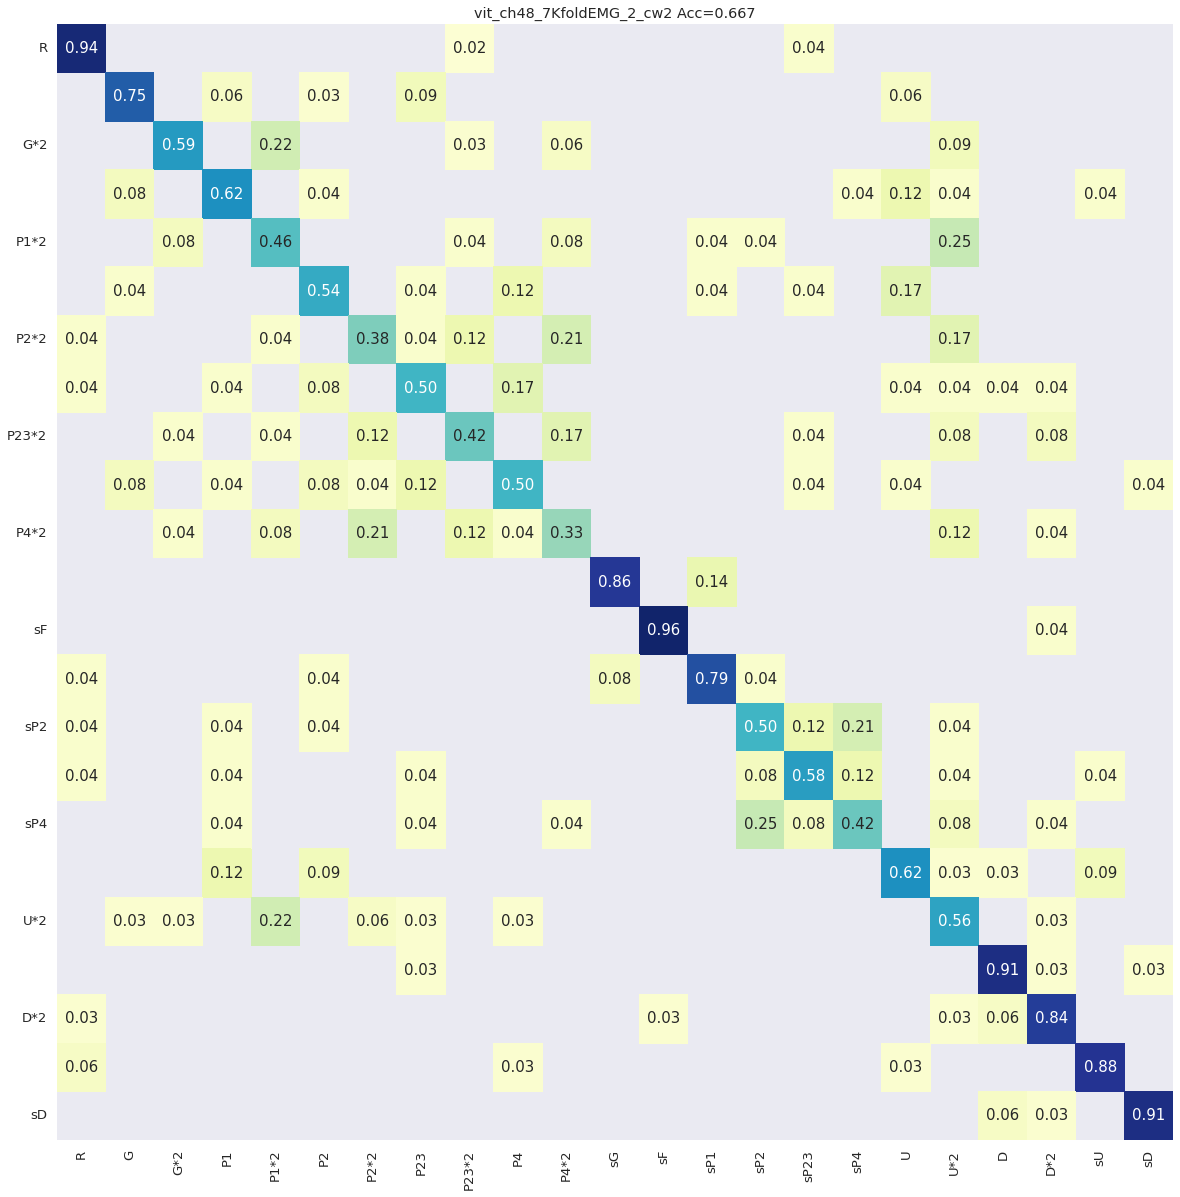

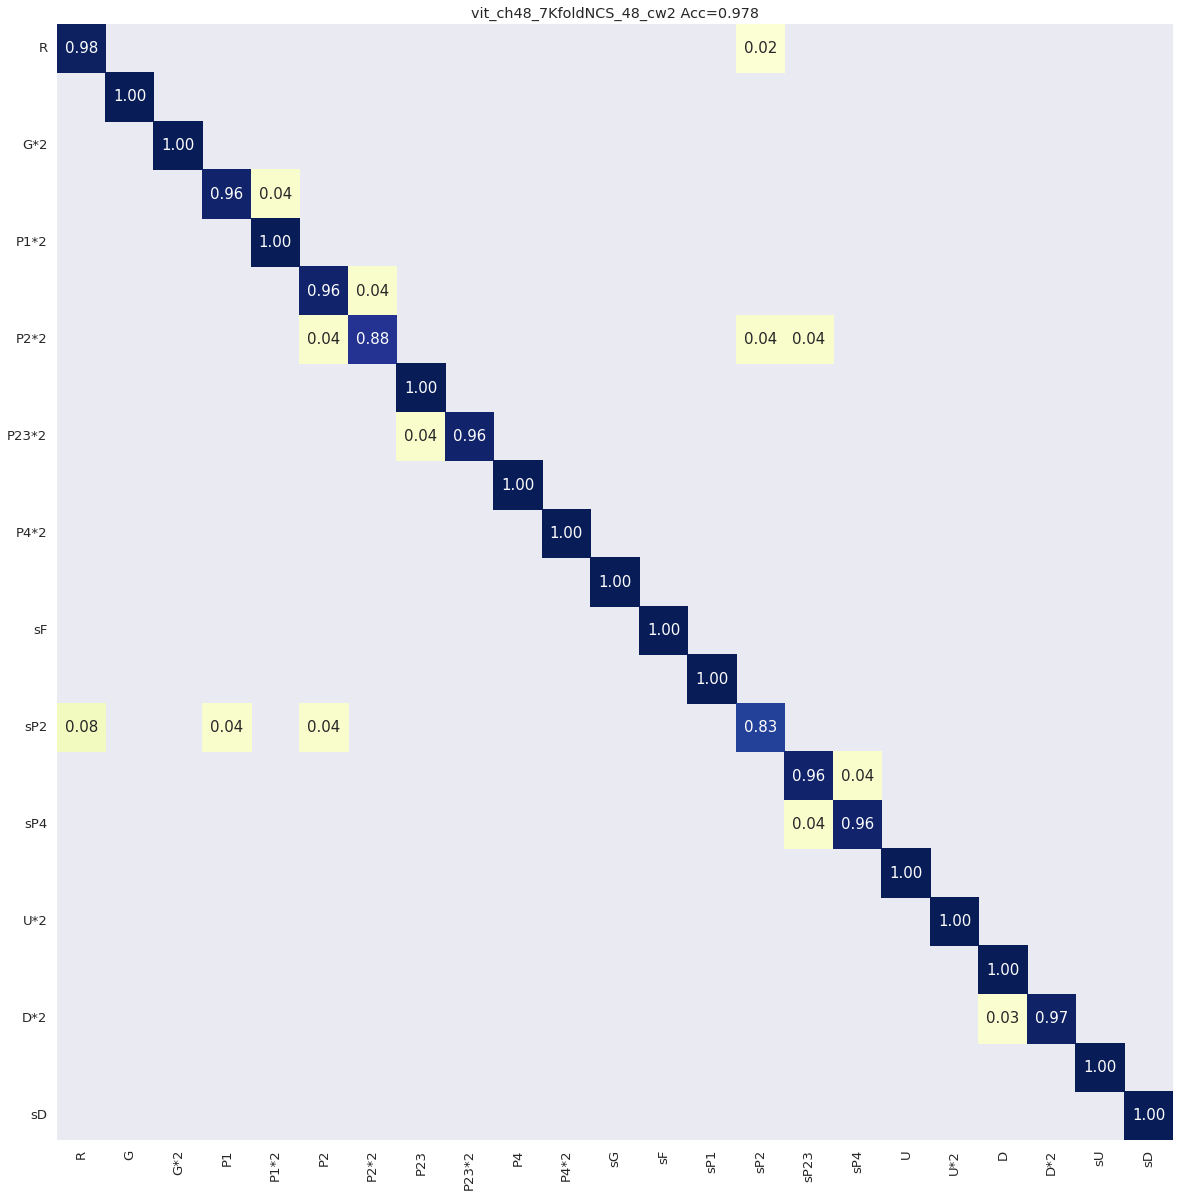

In [ ]:


def main_CV1(ExpVer,m,chNum):
    file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/data_all_multi6_wEMGfilt_0.1_5.npz"
    data=np.load(file_name_data)
    feature_2d_stft=data['feature_2d_stft']
    feature_2d_stft2=data['feature_2d_stft2']
    feature_2d_cwt=data['feature_2d_cwt']
    feature_2d_cwt2=data['feature_2d_cwt2']
    feature_2d_cwt3=data['feature_2d_cwt3']

    label_all=data['label_all']
    caseNum_all=data['caseNum_all']

    
    opt1={'method':m,'image_size':56,'patch_size':7}
    opt2={'method':m,'image_size':40,'patch_size':5}
    opt3={'method':m,'image_size':125,'patch_size':5}

    opt_list=[opt1,opt2,opt3,opt3,opt3]

    
    in_ch=chNum
    # if use EMG 2 channels 
    if chNum==2:
      channel=np.linspace(48,49,2).astype(int) 
      channelName='EMG_2'
    # if use NCS 48 channels 
    if chNum==48:
      channel=np.linspace(0,47,48).astype(int) 
      channelName='NCS_48'
    
    num_class=23
    k=7
    
    n_re=1
    cm=[]
    cm_norm=[]
    cm_all=[]
    acc=[]
    acc_all=[]
    y=[]
    test_ind_all=[]
    feature_list=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3]
    feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
    if __name__ == '__main__':
      
        i=3
  
      
        cm_norm_temp,cm_temp,cm_all_temp,acc_temp,acc_all_temp,y_temp,test_ind_all_temp=kFCV(feature_list[i][:,channel,:,:],label_all,in_ch,num_class,opt=opt_list[i],case=caseNum_all,del_case=del_case)
        print(feature_listName[i])
        cm_norm.append(cm_norm_temp)
        cm.append(cm_temp)
        cm_all.append(cm_all_temp)
        acc.append(acc_temp)
        acc_all.append(acc_all_temp)
        y.append(y_temp)
        test_ind_all.append(test_ind_all_temp)



   


    SaveName='ch48_'+str(k)+m+channelName
  

    plotfigFullClass(cm_norm[0],acc[0],'vit_'+SaveName+'_cw2',ExpVer)
 
    np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/vit_"+SaveName+"_cw2.npz",\
                    cm_norm=cm_norm,cm=cm,cm_all=cm_all,acc=acc,acc_all=acc_all,y=y,test_ind_all=test_ind_all,\
                   parameter_vit=parameter_vit)
k=7
n_re=1

m1='Kfold'
m2='groupKfold'
m3='group'
del_case=[]

ExpVer='emg3'


main_CV1(ExpVer,m1,2)
main_CV1(ExpVer,m1,48)

[48 49]


In [ ]:


def plotfigFullClass(cm,acc,tle,ExpVer):

    parent_dir = r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/"
    path1 = os.path.join(parent_dir, 'cm_fig')
    os.makedirs(path1, exist_ok = True) 
    path1 = os.path.join(parent_dir, 'npyFile')
    os.makedirs(path1, exist_ok = True) 



    labelNum=str(1)  #labelling method 1,2,3,4
    size=15
    name1=["R", "G","G*2","P1","P1*2","P2","P2*2","P23","P23*2","P4","P4*2","sG","sF","sP1","sP2","sP23","sP4","U","U*2","D","D*2","sU","sD"]
    name2=name1
    w=20 #fig size 1      change when label num change
    h=22   #fig size 2
    
    # true_num=0
    # for i in range (len(cm)):
    #   true_num=true_num+ cm[i,i]
    # acc=true_num/np.sum(cm)   
    
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=1.2)
    mask = np.zeros_like(df_cm)
    mask[np.where(cm==0)] = True
    
    sn.heatmap(df_cm, cmap="YlGnBu",fmt=".2f",vmin=0, vmax=1.0,annot=True,mask=mask,square=True,cbar=False,annot_kws={"size": size,'fontsize':15})
 
    s01=' Acc={n:.3f}'.format(n=acc)
    #plt.text(a,b,s01,fontsize=size)
    
    tleSave=tle
    plt.title(tle+s01)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    
    plt.savefig(parent_dir+r"cm_fig/"+tleSave+"CM.png", dpi=300)




In [ ]:
# load saved tested results 

from google.colab import drive
drive.mount('/content/drive')
ExpVer='2_9'
data=np.load(r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/"+"vit_ch48_group7fold_ensemble5.npz")
cm=data['cm']
acc_all=data['acc_all']
acc=data['acc']
print(acc)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: ignored